In [144]:
# Required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import math
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from torch.utils.data import DataLoader
from functions.dateTrans import datesDataset  # Ensure this import works
%matplotlib inline

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [44]:
# Prepare the dataset
dataset = datesDataset()
human_vocab = dataset.humanVocab
machine_vocab = dataset.machineVocab
max_length = dataset.outputLength

In [34]:
# Assuming the <SOS> and <EOS> symbols are part of your vocabularies
SOS_token = human_vocab['<SOS>']
EOS_token = human_vocab['<EOS>']


In [35]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [41]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(max_length):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [42]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        _, _, input_tensor, target_tensor = data

        # Move tensors to the correct device
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [147]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

# import matplotlib.pyplot as plt
# plt.switch_backend('agg')
# import matplotlib.ticker as ticker
# import numpy as np
# %matplotlib inline

# Plotting results
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    # plt.show()

# # Plotting results
# def showPlot(points):
#     plt.figure()
#     fig, ax = plt.subplots()
#     loc = ticker.MultipleLocator(base=0.2)
#     ax.yaxis.set_major_locator(loc)
#     plt.plot(points)

In [120]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

0m 12s (- 1m 51s) (100 10%) 0.5905
0m 24s (- 1m 38s) (200 20%) 0.2125
0m 36s (- 1m 25s) (300 30%) 0.0715
0m 48s (- 1m 12s) (400 40%) 0.0307
1m 0s (- 1m 0s) (500 50%) 0.0158
1m 12s (- 0m 48s) (600 60%) 0.0172
1m 24s (- 0m 36s) (700 70%) 0.0143
1m 36s (- 0m 24s) (800 80%) 0.0036
1m 48s (- 0m 12s) (900 90%) 0.0099
2m 0s (- 0m 0s) (1000 100%) 0.0221


<Figure size 640x480 with 0 Axes>

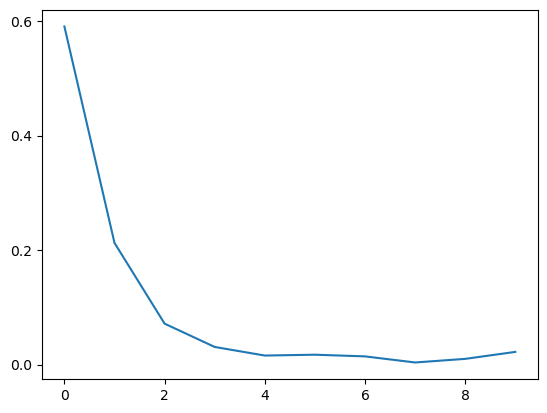

In [161]:
hidden_size = 1024
batch_size_use = 32
nsim = 1000

# DataLoader to handle batching
train_dataloader = DataLoader(dataset, batch_size=batch_size_use, shuffle=True)

encoder = EncoderRNN(len(human_vocab), hidden_size).to(device)
decoder = DecoderRNN(hidden_size, len(machine_vocab)).to(device)

train(train_dataloader, encoder, decoder, n_epochs=nsim, print_every=(nsim/10), plot_every=(nsim/10))

In [130]:
def evaluate(encoder, decoder, human_readable, human_vocab, max_length):
    with torch.no_grad():
        # Prepare the input tensor
        input_tensor = torch.LongTensor(dataset.string_to_int(human_readable, max_length, human_vocab)).unsqueeze(0).to(device)

        # Forward pass through encoder
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        # Forward pass through decoder
        decoder_outputs, decoder_hidden, _ = decoder(encoder_outputs, encoder_hidden)

        # Take the top one word from the output
        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze().detach().cpu().numpy()

        # Convert the indices to the machine readable date
        decoded_words = [dataset.invMachineVocab[idx] for idx in decoded_ids if idx not in (dataset.humanVocab['<SOS>'], dataset.humanVocab['<EOS>'], dataset.humanVocab['<pad>'])]

    return ''.join(decoded_words)

In [72]:
def evaluateRandomly(encoder, decoder, dataset, n=10):
    for i in range(n):
        sample = random.choice([dataset[i] for i in range(len(dataset))])
        human_readable, machine_readable, _, _ = sample

        print('>', human_readable)
        print('=', machine_readable)
        
        output_sentence = evaluate(encoder, decoder, human_readable, dataset.humanVocab, dataset.inputLength)
        print('<', output_sentence)
        print('')

In [133]:
def compute_accuracy(encoder, decoder, dataset):
    total_chars = 0
    correct_chars = 0
    for i in range(len(dataset)):
        human_readable, machine_readable, _, _ = dataset[i]
        prediction = evaluate(encoder, decoder, human_readable, dataset.humanVocab, dataset.inputLength)

        # Ensure that the lengths of prediction and machine_readable are the same for character-wise comparison
        min_length = min(len(prediction), len(machine_readable))
        total_chars += min_length
        correct_chars += sum(1 for j in range(min_length) if prediction[j] == machine_readable[j])

        # If you also want to count the missing or extra characters as incorrect
        total_chars += abs(len(prediction) - len(machine_readable))

    accuracy = correct_chars / total_chars if total_chars > 0 else 0
    return accuracy


In [170]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder, dataset, n=7)

> 17.05.1980
= 1980-05-17
< 1980-05-17

> 27. jan. 2005
= 2005-01-27
< 2005-01-27

> 10 okt. 1997
= 1997-10-10
< 1997-10-10

> lørdag den 28. juli 1990
= 1990-07-28
< 1990-07-28

> 27/01/2017
= 2017-01-27
< 2017-01-27

> 26. november 1999
= 1999-11-26
< 1999-11-26

> 26.04.2005
= 2005-04-26
< 2005-04-26



In [167]:
from faker import Faker
fake = Faker()

Faker.seed(101)
random.seed(101)

accuracy = compute_accuracy(encoder, decoder, dataset) * 100
print(f"Model accuracy: {accuracy:.2f}%")

Model accuracy: 100.00%
